# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               EnsDb.Hsapiens.v86, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra,grid, ggh4x)

In [4]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/"
assets.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Assets/"

cell.ranger.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/cellranger.symlinks/"

step1.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/1_preprocessing/"
step2.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/2_PeaksReformat/"
step3.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/Analysys/3_SoupX/"

log.dir = "/nfs/lab/projects/mega_heart/CAREHF/multiome/log/"

In [7]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".3_SoupX.log", sep="")

In [8]:
log_open(log.file)

[1] "/nfs/lab/projects/mega_heart/CAREHF/multiome/log/2024-09-17.3_SoupX.log"

# Load sample list

In [9]:
# Load sample info
sample.info = read.table(paste(assets.dir, "sample.info", sep = ""), sep = "\t", header = TRUE)
# Build variables
sample.ls = sample.info$ID
cellranger.outs.ls = paste0(sample.info$CellRanger,
                            sample.info$Chamber, "/",
                            sample.info$ID, "/outs/")

# Check the paths r right
sample.ls[1]
cellranger.outs.ls[1]
length(sample.ls)

[1] "KA_49_1_2_KA_45_1_2"

[1] "/nfs/lab/projects/CARE_HF/DATA/multiome/LA/KA_49_1_2_KA_45_1_2/outs/"

[1] 36

In [10]:
head(sample.info, n=2)

,ID,Chamber,Donor,CellRanger
,<chr>,<chr>,<chr>,<chr>
1,KA_49_1_2_KA_45_1_2,LA,HF3,/nfs/lab/projects/CARE_HF/DATA/multiome/
2,QY_1880_1_2_QY_1879_1_2,LA,D9,/nfs/lab/projects/CARE_HF/DATA/multiome/


# SoupX

In [11]:
Run_SoupX <- function(i) {
    gc(reset = TRUE)
    # Set sample variable
    sample = sample.ls[i]
    cellranger.dir <- cellranger.outs.ls[i]
    log_print(paste("Removing doublets via demuxlet of:", sample))
    # Load adata
    adata = readRDS(paste(step2.dir, sample, "_pre.filt.peaks.rds", sep = ""))
    #Read in RNA assay counts from filtered seurat object
    DefaultAssay(adata) <- 'RNA'
    toc = GetAssayData(object = adata, slot = "counts") #filtered cells
    #Read in raw RNA counts from CellRanger outputs
    tod = Seurat::Read10X_h5(file.path(cellranger.dir, 'raw_feature_bc_matrix.h5'))$`Gene Expression`
    #Compile necessary metadata (pull out the required metadata from the clustered filtered 
    #adata object; we need the UMAP coordinates (RD1 and RD2) and the cluster assignments at minimum)
    metadata <- (cbind(as.data.frame(adata[["umap.wnn"]]@cell.embeddings),
                       as.data.frame(Idents(adata))))
    colnames(metadata) <- c("RD1","RD2","Cluster")
    log_print("Check that TOC and TOD barcodes match")
    #Make sure the metadata BCs match the toc matrix barcodes
    log_print("Checking all necssary barcode and gene indices match")
    if (FALSE %in% (row.names(metadata) %in% colnames(toc)) == TRUE) {
      stop('Not all metadata barcodes found in toc')}
    if (FALSE %in% (colnames(toc) %in% row.names(metadata)) == TRUE) {
      stop('Not all toc barcodes found in metadata')}

    #Make sure the toc and tod indices match
    if (FALSE %in% (row.names(tod) %in% row.names(toc)) == TRUE) {
      stop("Not all tod genes found in toc")}
    if (FALSE %in% (row.names(toc) %in% row.names(tod)) == TRUE) {
      stop("Not all toc genes found in tod")}
    if (FALSE %in% (row.names(toc) == row.names(tod)) == TRUE) {
      stop("toc and tod gene indices don't match")
    }
    log_print("Looks good!")
    
    # Create a Soup Channel object and add in the metadata
    sc <- SoupChannel(tod,toc)
    sc <- setDR(sc,metadata[colnames(sc$toc),c("RD1","RD2")])
    sc <- setClusters(sc,setNames(metadata$Cluster,rownames(metadata)))
    # Autodetect noise
    sc <- autoEstCont(sc)
        #Output the estimated percentage of background as a separate file
        background <- sc$soupProfile[order(sc$soupProfile$est,decreasing=TRUE),] 
        write.table(background, paste(step3.dir, sample, "_SoupX_est_background.csv", sep = ""),
                    sep='\t', col.names = TRUE, row.names = TRUE, quote = FALSE) 
        # Grab Contamination Fraction
        contamination_fraction <- mean(sc$metaData$rho*100)
    # round soupX count for downstream
    out <- adjustCounts(sc, roundToInt=TRUE)

    # Store raw RNA data as another assay (RNA_raw)
    DefaultAssay(adata) <- 'RNA'
    raw_rna <-  GetAssayData(object = adata, slot = "counts")
    raw_rna_assay <- CreateAssayObject(counts = raw_rna)
    adata[['RNA_raw']] <- raw_rna_assay
    DefaultAssay(adata) <- 'RNA_raw'
    # Sobstitute RNA assay with soupX correct assay
    adata[['RNA']] = NULL
    adata[['RNA']] = CreateAssayObject(counts = out)
    
    ### Save intermediate RDS
    file = paste(step3.dir, sample, "_pre.filt.peaks.SoupX.rds", sep = "")
    saveRDS(adata, file = file)  
    
    # Pile up QC 
    qc.data$sample = rbind(qc.data$sample, sample)
    qc.data$contamination_fraction <- rbind(qc.data$contamination_fraction, contamination_fraction)
    return(qc.data)
}

In [12]:
cores <- 4
cl <- makeCluster(cores)
setDefaultCluster(cl)

log_print(paste("Running SoupX"))
qc.data.ls = NULL
qc.data = NULL
# Process samples
qc.data.ls = mclapply(1:length(sample.ls), function(i) Run_SoupX(i), mc.cores = cores)

[1] "Running SoupX"


In [13]:
qc.data <- as.data.frame(do.call(rbind, qc.data.ls))
qc.data$contamination_fraction = as.numeric(qc.data$contamination_fraction)
# Ensure the sample column is a character vector
qc.data$sample <- as.character(qc.data$sample)
qc.data = merge(qc.data, sample.info, by.x = "sample", by.y = "ID")

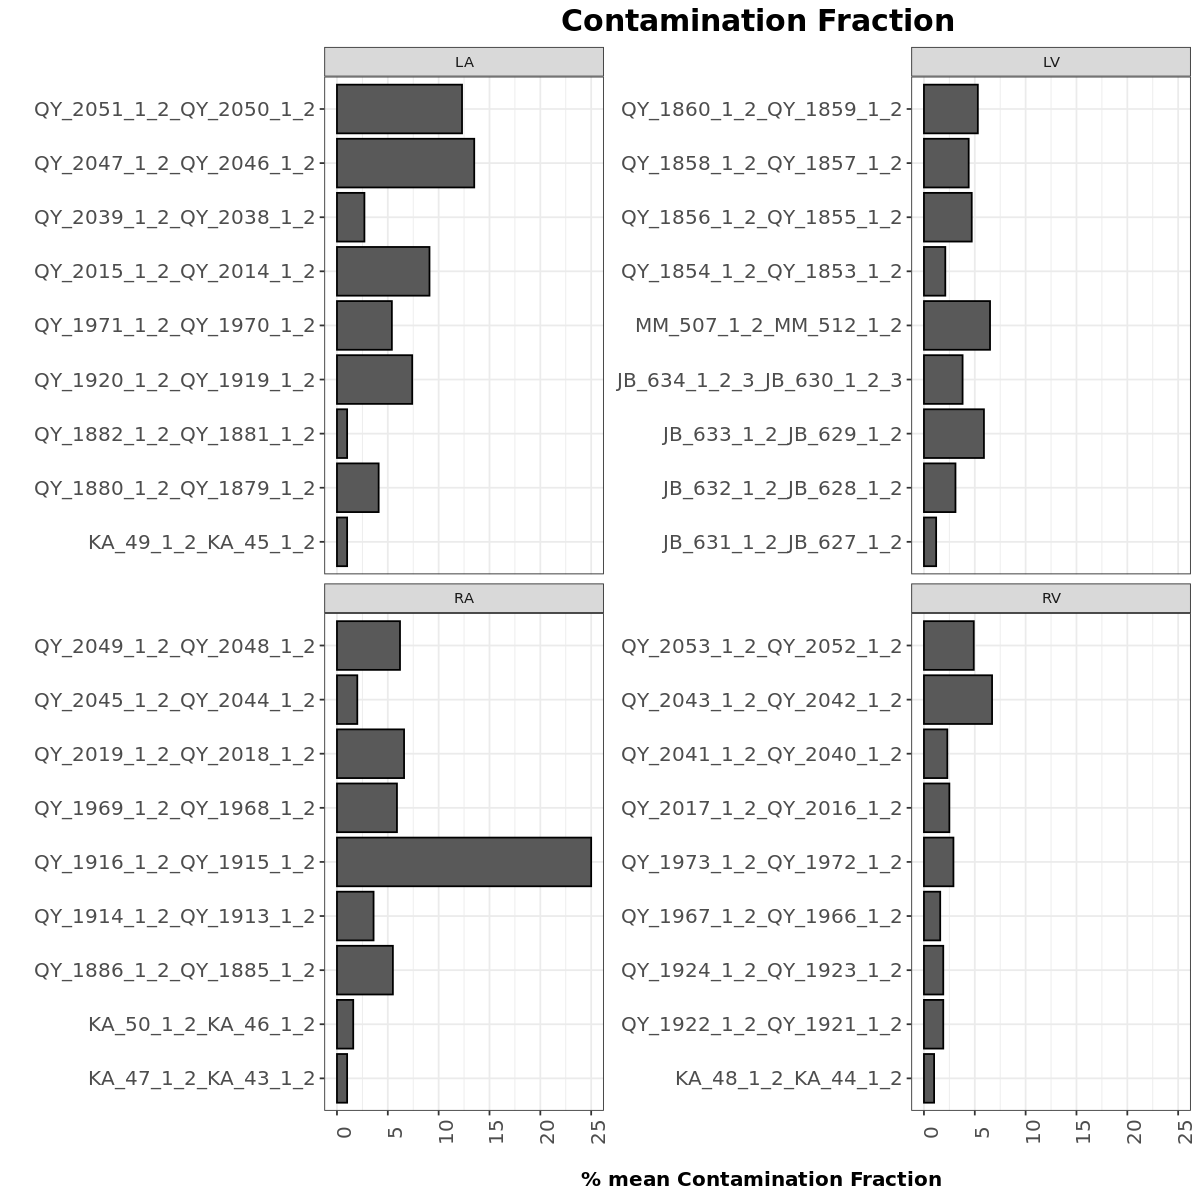

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)
gg1 = ggplot(qc.data, aes(x = sample, y = contamination_fraction)) + 
            theme_bw() +
            labs(y = "\n % mean Contamination Fraction", x = "", title = "Contamination Fraction") +
            geom_bar(stat = "identity", 
                     colour = "black") +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) +
            coord_flip() +
            facet_wrap(. ~ Chamber, scales = "free_y")
gg1